# SensorMNIST 10 class classification (Map + Begin/End)

In order to show how this can be used as a drop-in replacement, this was taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

It was only modified to load SensorMNIST instead of CIFAR10, removed all comments, and moved to binary classification, and increase the batch size

NOTE: you will have to change the root and subdir paths to make the location of your StarCraftSensor installation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import os, sys
# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
sys.path.append(os.path.join(ipynb_dir, '..'))  # Needed for import below

from sc2sensor.dataset import SensorMNIST
from sc2sensor.dataset import MAP_CLASSES


root = '/local/scratch/a/shared/starcraft_shared'
subdir = 'starcraft-sensor-dataset'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 256

trainset = SensorMNIST(root=root, subdir=subdir, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16)

testset = SensorMNIST(root=root, subdir=subdir, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16)

classes = MAP_CLASSES
print(classes)

Using cached CSV metadata
Using cached data at /local/scratch/a/shared/starcraft_shared/starcraft-sensor-dataset/SensorMNIST_train.npz
Using cached CSV metadata
Using cached data at /local/scratch/a/shared/starcraft_shared/starcraft-sensor-dataset/SensorMNIST_test.npz
(('Acolyte LE', 'Beginning'), ('Acolyte LE', 'End'), ('Abyssal Reef LE', 'Beginning'), ('Abyssal Reef LE', 'End'), ('Ascension to Aiur LE', 'Beginning'), ('Ascension to Aiur LE', 'End'), ('Mech Depot LE', 'Beginning'), ('Mech Depot LE', 'End'), ('Odyssey LE', 'Beginning'), ('Odyssey LE', 'End'))


tensor(-1.) tensor(1.)
tensor(0.) tensor(1.)
0.0 1.0


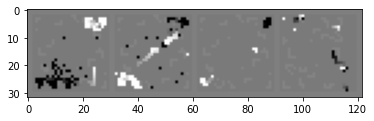

('Odyssey LE', 'Beginning') ('Odyssey LE', 'Beginning') ('Odyssey LE', 'Beginning') ('Abyssal Reef LE', 'End')


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    print(img.min(), img.max())
    img = img / 2 + 0.5     # unnormalize
    print(img.min(), img.max())
    npimg = img.numpy()
    print(npimg.min(), npimg.max())
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = images[:min(4, batch_size)], labels[:min(4, batch_size)]

# show images
imshow(torchvision.utils.make_grid(images[:min(4, batch_size)]))
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(min(4, batch_size))))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)
net(images.to(device))

tensor([[ 0.0241,  0.0546, -0.0038,  0.0709,  0.0173,  0.1068, -0.0919,  0.0301,
          0.0551, -0.0044],
        [ 0.0160,  0.0510, -0.0132,  0.0699,  0.0076,  0.1015, -0.0863,  0.0350,
          0.0623, -0.0003],
        [ 0.0156,  0.0607, -0.0096,  0.0815,  0.0097,  0.1005, -0.0949,  0.0292,
          0.0557,  0.0047],
        [ 0.0140,  0.0549, -0.0097,  0.0736,  0.0201,  0.1098, -0.0992,  0.0335,
          0.0580,  0.0008]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import time
start = time.time()
for epoch in range(20):  # loop over the dataset multiple times
    prefix = 'binary-sensor-mnist'
    model_file = os.path.join(model_dir, f'{prefix}-epoch-{epoch+1}.pth')
    next_model_file = os.path.join(model_dir, f'{prefix}-epoch-{epoch+2}.pth')
    if os.path.exists(next_model_file):
        print(f'Skipping epoch {epoch+1} since next epoch is saved')
        continue
    elif os.path.exists(model_file):
        net.load_state_dict(torch.load(model_file))
        print(f'Loaded pretrained model {model_file}')
        continue
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, cumulative time: {time.time() - start:.2f}')
            running_loss = 0.0
    # Save model every epoch 
    torch.save(net.state_dict(), model_file)
    print(f'Saved model into {model_file}')

print('Finished Training')

In [7]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device)).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.1f} %')

Accuracy of the network on the 10000 test images: 77.6 %


In [8]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

all_ground_truths = []
all_predictions = []

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device)).cpu()
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            all_ground_truths.append(label.item())
            all_predictions.append(prediction.item())


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: ('Acolyte LE', 'Beginning') is 75.7 %
Accuracy for class: ('Acolyte LE', 'End') is 82.3 %
Accuracy for class: ('Abyssal Reef LE', 'Beginning') is 84.9 %
Accuracy for class: ('Abyssal Reef LE', 'End') is 66.2 %
Accuracy for class: ('Ascension to Aiur LE', 'Beginning') is 81.8 %
Accuracy for class: ('Ascension to Aiur LE', 'End') is 77.9 %
Accuracy for class: ('Mech Depot LE', 'Beginning') is 76.9 %
Accuracy for class: ('Mech Depot LE', 'End') is 75.1 %
Accuracy for class: ('Odyssey LE', 'Beginning') is 76.3 %
Accuracy for class: ('Odyssey LE', 'End') is 78.9 %


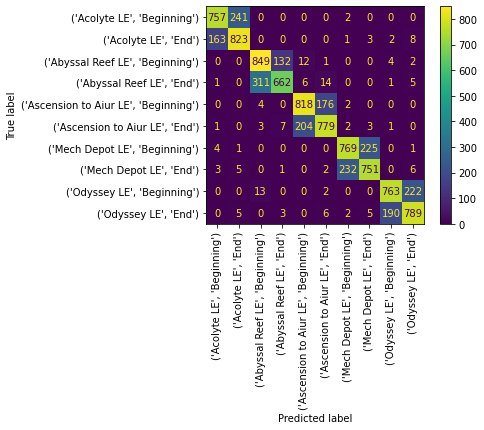

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(all_ground_truths, all_predictions,
                                        labels=range(10), display_labels=classes, xticks_rotation='vertical')
plt.show()